# Large-scale multi-label text classification

**Author:** [Sayak Paul](https://twitter.com/RisingSayak), [Soumik Rakshit](https://github.com/soumik12345)<br>
**Date created:** 2020/09/25<br>
**Last modified:** 2020/09/26<br>
**Description:** Implementing a large-scale multi-label text classification model.

## Introduction

In this example, we will build a multi-label text classifier to predict the subject areas
of arXiv papers from their abstract bodies. This type of classifier can be useful for
conference submission portals like [OpenReview](https://openreview.net/). Given a paper
abstract, the portal could provide suggestions for which areas the paper would
best belong to.

The dataset was collected using the
[`arXiv` Python library](https://github.com/lukasschwab/arxiv.py)
that provides a wrapper around the
[original arXiv API](http://arxiv.org/help/api/index).
To learn more about the data collection process, please refer to
[this notebook](https://github.com/soumik12345/multi-label-text-classification/blob/master/arxiv_scrape.ipynb).
Additionally, you can also find the dataset on
[Kaggle](https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts).

## Imports

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

2021-12-04 18:06:26.784244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-04 18:06:26.784266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Perform exploratory data analysis

In this section, we first load the dataset into a `pandas` dataframe and then perform
some basic exploratory data analysis (EDA).

In [2]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


Our text features are present in the `summaries` column and their corresponding labels
are in `terms`. As you can notice, there are multiple categories associated with a
particular entry.

In [3]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


Real-world data is noisy. One of the most commonly observed source of noise is data
duplication. Here we notice that our initial dataset has got about 13k duplicate entries.

In [4]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


Before proceeding further, we drop these entries.

In [5]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


As observed above, out of 3,157 unique combinations of `terms`, 2,321 entries have the
lowest occurrence. To prepare our train, validation, and test sets with
[stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop
these terms.

In [6]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

In [7]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [8]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


## Multi-label binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

In [9]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


2021-12-04 18:07:19.788021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-04 18:07:19.788053: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-04 18:07:19.788073: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch-desktop): /proc/driver/nvidia/version does not exist
2021-12-04 18:07:19.788629: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-04 18:07:19.885044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR O

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.SE', 'cs.NI', 'cs.CG', 'stat.CO', 'I.2.6', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'math.DS', 'cs.CC', '68T05', 'quant-ph', 'I.4.6', 'physics.data-an', 'physics.soc-ph', 'physics.ao-ph', 'econ.EM', 'cs.DM', 'q-bio.GN', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'hep-ex', 'cond-mat.mtrl-sci', '68T10', 'physics.geo-ph', 'physics.optics', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', '6

Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

In [10]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
train_df

,titles,summaries,terms
7643,Unsupervised Hard Example Mining from Videos f...,Important gains have recently been obtained in...,[cs.CV]
40357,iPerceive: Applying Common-Sense Reasoning to ...,Most prior art in visual understanding relies ...,"[cs.CV, cs.AI, cs.LG, cs.MM, eess.IV]"
2914,BBN: Bilateral-Branch Network with Cumulative ...,Our work focuses on tackling the challenging b...,"[cs.CV, cs.LG]"
25236,Assigning Apples to Individual Trees in Dense ...,We propose a 3D color point cloud processing p...,[cs.CV]
10882,Towards Adversarially Robust and Domain Genera...,Stereo matching has recently witnessed remarka...,"[cs.CV, cs.AI]"
...,...,...,...
44051,Matrix Factorization Equals Efficient Co-occur...,Matrix factorization is a simple and effective...,"[cs.LG, stat.ML]"
22962,Temporal Graph Modeling for Skeleton-based Act...,"Graph Convolutional Networks (GCNs), which mod...","[cs.CV, cs.GR]"
29731,Deep Hashing for Secure Multimodal Biometrics,"When compared to unimodal systems, multimodal ...","[cs.CV, cs.AI, cs.IT, math.IT]"
4415,Learning Disentangled Representations via Mutu...,"In this paper, we investigate the problem of l...","[stat.ML, cs.LG]"


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

In [12]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.499227
std         41.489081
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number
based on the split). So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets that would go straight to the text
classifier model.

In [94]:
#text_vectorizer = layers.TextVectorization(
#    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
#)

maxWords = 50000
maxSeqLen = 250
embeddingDim = 150

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['summaries'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = tokenizer.texts_to_sequences(train_df['summaries'].values)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxSeqLen)

X_test= tokenizer.texts_to_sequences(test_df['summaries'].values)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxSeqLen)

X_val = tokenizer.texts_to_sequences(val_df['summaries'].values)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxSeqLen)

print(X_train.shape)
print(X_test.shape)


Found 239869 unique tokens.
(32985, 250)
(1833, 250)


In [95]:
train_labels = tf.ragged.constant(train_df["terms"].values)
train_label_binarized = lookup(train_labels).numpy()
print(label_binarized.shape)

test_labels = tf.ragged.constant(test_df["terms"].values)
test_label_binarized = lookup(test_labels).numpy()
print(test_label_binarized.shape)

val_labels = tf.ragged.constant(val_df["terms"].values)
val_label_binarized = lookup(val_labels).numpy()
print(val_label_binarized.shape)
#    dataset = tf.data.Dataset.from_tensor_slices(
#        (dataframe["summaries"].values, label_binarized)
#    )
#    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
#    dataset = dataset.map(unify_text_length, num_parallel_calls=auto).cache()
#    return dataset.batch(batch_size)


(1, 153)
(1833, 153)
(1833, 153)


Now we can prepare the `tf.data.Dataset` objects.

In [96]:
#train_dataset = make_dataset(train_df, is_train=True)
#validation_dataset = make_dataset(val_df, is_train=False)
#test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [97]:
#text_batch, label_batch = next(iter(train_dataset))

#for i, text in enumerate(text_batch[:5]):
#    label = label_batch[i].numpy()[None, ...]
#    print(f"Abstract: {text[0]}")
#    print(f"Label(s): {invert_multi_hot(label[0])}")
#    print(" ")

## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the abstracts.

In [98]:
train_df["total_words"] = train_df["summaries"].str.split().str.len()
vocabulary_size = train_df["total_words"].max()
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 498


We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.

A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.

## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

In [99]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Embedding(maxWords,embeddingDim, input_length=X_train.shape[1]),
            layers.SpatialDropout1D(0.1),
            layers.LSTM(100, dropout=0.1, recurrent_dropout=0.1),
            layers.Dense(153, activation="softmax"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in
[Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

Epoch 1/20
464/464 [==============================] - 114s 241ms/step - loss: 0.0559 - accuracy: 0.5064 - val_loss: 0.0280 - val_accuracy: 0.5732
Epoch 2/20
464/464 [==============================] - 112s 242ms/step - loss: 0.0277 - accuracy: 0.5308 - val_loss: 0.0277 - val_accuracy: 0.4213
Epoch 3/20
464/464 [==============================] - 112s 241ms/step - loss: 0.0276 - accuracy: 0.5320 - val_loss: 0.0278 - val_accuracy: 0.4213
Epoch 4/20
464/464 [==============================] - 112s 241ms/step - loss: 0.0276 - accuracy: 0.5409 - val_loss: 0.0274 - val_accuracy: 0.5978
Epoch 5/20
464/464 [==============================] - 112s 241ms/step - loss: 0.0266 - accuracy: 0.6664 - val_loss: 0.0263 - val_accuracy: 0.6599
Epoch 6/20
464/464 [==============================] - 117s 251ms/step - loss: 0.0250 - accuracy: 0.7343 - val_loss: 0.0254 - val_accuracy: 0.7160
Epoch 7/20
464/464 [==============================] - 119s 256ms/step - loss: 0.0240 - accuracy: 0.7707 - val_loss: 0.0259 -

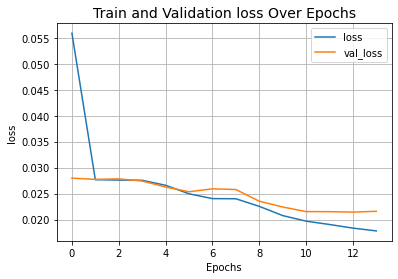

KeyError: 'categorical_accuracy'

In [101]:
epochs = 20
trainingDatset = tf.data.Dataset.from_tensor_slices(X_train)
validationDataset = tf.data.Dataset.from_tensor_slices(X_val)

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

history = shallow_mlp_model.fit(
    X_train, train_label_binarized, epochs=epochs, batch_size = 64, validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()




While training, we notice an initial sharp fall in the loss followed by a gradual decay.

### Evaluate the model

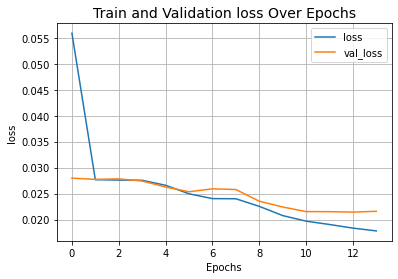

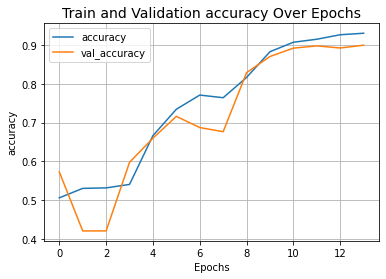

58/58 [==============================] - 2s 33ms/step - loss: 0.0210 - accuracy: 0.9013
Accuracy on the test set: 90.13%.


In [103]:
plot_result("loss")
plot_result("accuracy")
_, acc = shallow_mlp_model.evaluate(X_test,test_label_binarized)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

The trained model gives us an evaluation accuracy of ~87%.

## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

The prediction results are not that great but not below the par for a simple model like
ours. We can improve this performance with models that consider word order like LSTM or
even those that use Transformers ([Vaswani et al.](https://arxiv.org/abs/1706.03762)).

## Acknowledgements

We would like to thank [Matt Watson](https://github.com/mattdangerw) for helping us
tackle the multi-label binarization part and inverse-transforming the processed labels
to the original form.